<h1> AT&T Spam detector <h1>

One of the main pain point that AT\&T users are facing is constant exposure to SPAM messages.

AT\&T has been able to manually flag spam messages for a time, but they are looking for an automated way of detecting spams to protect their users.

The goal is to build a spam detector, that can automatically flag spams as they come based sollely on the sms' content.

<h2> Import librairies <h2>

In [2]:
import tensorflow as tf

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,  ConfusionMatrixDisplay, RocCurveDisplay
import sklearn
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import pandas as pd 
import numpy as np
import plotly.express as px
from spacy.lang.en.stop_words import STOP_WORDS
import en_core_web_md
import os
import io
import matplotlib.pyplot as plt

<h2> Upload and take a first look at the data <h2>

<h4> Upload <h4>

In [3]:
dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", error_bad_lines=False)

C:\Users\flori\AppData\Local\Temp\ipykernel_6856\3782423844.py:1: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  dataset = pd.read_csv('spam.csv', encoding = "ISO-8859-1", error_bad_lines=False)


<h4> Preview and basic stats <h4>

In [4]:
print(f"Number of rows : {dataset.shape[0]}")
print()

print("Display of dataset: ")
display(dataset.head())
print()

print("Basics statistics: ")
display(dataset.describe(include='all'))
print()

print("Percentage of missing values: ")
display(100 * dataset.isnull().sum() / dataset.shape[0])

Number of rows : 5572

Display of dataset: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN



Basics statistics: 


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
count,5572,5572,50,12,6
unique,2,5169,43,10,5
top,ham,"Sorry, I'll call later","bt not his girlfrnd... G o o d n i g h t . . .@""","MK17 92H. 450Ppw 16""","GNT:-)"""
freq,4825,30,3,2,2



Percentage of missing values: 


v1             0.000000
v2             0.000000
Unnamed: 2    99.102656
Unnamed: 3    99.784637
Unnamed: 4    99.892319
dtype: float64

We can see 3 useless columns with barely only missing values (Unnamed: 2,Unnamed: 3,Unnamed: 4), the other 2 columns correspond to the message (v2) and to the tag attributed to the message (spam for the spam and ham for the normal messages). In those two usefull other columns we can be happy that there is no missing values.

<h2> EDA and cleaning <h2>

<h4> Cleaning <h4>

In [5]:
dataset = dataset.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)
dataset = dataset.rename(columns = {'v1': 'label', 'v2': 'message'})

<h4> Exploration <h4>

In [6]:
dataset['type'] = dataset.loc[:,'message'].apply(lambda x : 'str' if type(x) == str else 'other')

In [7]:
dataset['type'] = dataset.loc[:,'message'].apply(lambda x : 'str' if type(x) == str else 'other')
fig_type = px.pie(dataset, values= dataset['type'].value_counts().values, names=dataset['type'].value_counts().index, title='Data type proportion', width = 700, height = 500)
fig_type.update(layout=dict(title=dict(x=0.5)))
dataset = dataset.drop('type', axis= 1)
fig_type.show()

A good thing is that our feature (message) columns is homogenous, composed only of text. We will therefore have to do some preprocessing on the data in order to be able to use it for our model.

In [8]:
fig_target =  px.pie(dataset, values= dataset['label'].value_counts().values, names=dataset['label'].value_counts().index, title = 'Label proportion', width = 700, height = 500)
fig_target.update(layout=dict(title=dict(x=0.5)))
fig_target.show()

Sadly it seems that our target classes is imbalance with much more legit message than spam, we risk to have false negative.

<h2> Preprocessing <h2>

<h4> Keep only the alpha numeric caracters <h4>

In [9]:

dataset["message_clean"] = dataset["message"].apply(lambda x:''.join(ch for ch in x if ch.isalnum() or ch==" " or ch=="'"))
dataset["message_clean"] = dataset["message_clean"].apply(lambda x: x.replace(" +"," ").lower().strip())

<h4> Lemmatization <h4>

In [10]:
nlp = en_core_web_md.load()
dataset["message_clean"] = dataset["message_clean"].apply(lambda x: " ".join([token.lemma_ for token in nlp(x) if (token.lemma_ not in STOP_WORDS) and (token.text not in STOP_WORDS)]))
mask = dataset.message_clean.apply(lambda x: type(x)==str)

<h4> Tokenization <h4>

In [11]:
tokenizer = tf.keras.preprocessing.text.Tokenizer() # instanciate the tokenizer
tokenizer.fit_on_texts(dataset.message_clean)
dataset["message_encoded"] = tokenizer.texts_to_sequences(dataset.message_clean)

<h4> Padding <h4>

In [12]:
message_pad = tf.keras.preprocessing.sequence.pad_sequences(dataset["message_encoded"], padding="post")

In [13]:

vocab_size = len(tokenizer.word_index)
print('Vocabulary size :',vocab_size)
dataset.head()

Vocabulary size : 8198


,label,message,message_clean,message_encoded
0,ham,"Go until jurong point, crazy.. Available only ...",jurong point crazy available bugis n great wor...,"[3624, 229, 444, 461, 940, 31, 48, 203, 941, 7..."
1,ham,Ok lar... Joking wif u oni...,ok lar joke wif u oni,"[7, 193, 462, 289, 1, 1454]"
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry 2 wkly comp win fa cup final tkts 2...,"[10, 301, 2, 530, 658, 29, 1455, 844, 420, 145..."
3,ham,U dun say so early hor... U c already then say...,u dun early hor u c,"[1, 124, 149, 2373, 1, 78]"
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think usf live,"[700, 19, 659, 130]"


<h4> Train/Test split <h4>

In [14]:
xtrain, xval, ytrain, yval = train_test_split(message_pad,dataset.label, test_size=0.3)

<h4> Label encoding <h4>

In [15]:
encoder = LabelEncoder()
ytrain = encoder.fit_transform(ytrain)
yval = encoder.transform(yval)

In [16]:
train = tf.data.Dataset.from_tensor_slices((xtrain, ytrain))
val = tf.data.Dataset.from_tensor_slices((xval, yval))
train_batch = train.shuffle(len(train)).batch(64)
val_batch = val.shuffle(len(val)).batch(64)

In [17]:
Rajouter titre au dernière sous partie en se basant sur template?

Object `template` not found.


<h2> Model construction <h2>

<h4> Baseline <h4>

Simple model

In [18]:
baseline_model = tf.keras.Sequential([
                  # Couche d'Input Word Embedding           
                  tf.keras.layers.Embedding(vocab_size + 1, 8, input_shape=[message_pad.shape[1],],name="embedding"),
                  # Gobal average pooling
                  tf.keras.layers.GlobalAveragePooling1D(),

                  # Couche Dense classique
                  tf.keras.layers.Dense(16, activation='relu'),

                  tf.keras.layers.Dense(1, activation="sigmoid")
])

In [19]:
optimizer= tf.keras.optimizers.Adam()

baseline_model.compile(optimizer=optimizer,
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=tf.keras.metrics.BinaryAccuracy())

In [20]:
history = baseline_model.fit(train_batch, 
                    epochs=20, 
                    validation_data=val_batch)

Epoch 1/20
61/61 [==============================] - 1s 6ms/step - loss: 0.6267 - binary_accuracy: 0.8669 - val_loss: 0.5583 - val_binary_accuracy: 0.8636
Epoch 2/20
61/61 [==============================] - 0s 3ms/step - loss: 0.4819 - binary_accuracy: 0.8669 - val_loss: 0.4147 - val_binary_accuracy: 0.8636
Epoch 3/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3780 - binary_accuracy: 0.8669 - val_loss: 0.3653 - val_binary_accuracy: 0.8636
Epoch 4/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3533 - binary_accuracy: 0.8669 - val_loss: 0.3562 - val_binary_accuracy: 0.8636
Epoch 5/20
61/61 [==============================] - 0s 2ms/step - loss: 0.3445 - binary_accuracy: 0.8669 - val_loss: 0.3483 - val_binary_accuracy: 0.8636
Epoch 6/20
61/61 [==============================] - 0s 3ms/step - loss: 0.3355 - binary_accuracy: 0.8669 - val_loss: 0.3396 - val_binary_accuracy: 0.8636
Epoch 7/20
61/61 [==============================] - 0s 3ms/step - loss: 0.32

Rajouter graph, f1, et matrice de confusion 

In [21]:
from plotly import graph_objects as go
color_chart = ["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]

In [22]:
from plotly.subplots import make_subplots

In [23]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["loss"],
                          name="Training loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_loss"],
                          name="Validation loss",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val loss across epochs',
    xaxis_title='epochs',
    yaxis_title='Cross Entropy'    
)
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()


In [24]:
fig = go.Figure(data=[
                      go.Scatter(
                          y=history.history["binary_accuracy"],
                          name="Training accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[0]
                          )),
                      go.Scatter(
                          y=history.history["val_binary_accuracy"],
                          name="Validation accuracy",
                          mode="lines",
                          marker=dict(
                              color=color_chart[1]
                          ))
])
fig.update_layout(
    title='Training and val accuracy across epochs',
    xaxis_title='epochs',
    yaxis_title='Accuracy'    
)
fig.update(layout=dict(title=dict(x=0.5)))
fig.show()

The accuracy of the baseline model improved very quickly! Now let's check the F1-score as we suspected high false negative due to the imbalance:

In [25]:
Y_train_pred = baseline_model.predict(xtrain)
Y_test_pred = baseline_model.predict(xval)
Y_train_pred = Y_train_pred.reshape(-1)
Y_test_pred = Y_test_pred.reshape(-1)
Y_train_pred= pd.DataFrame(Y_train_pred)
Y_test_pred= pd.DataFrame(Y_test_pred)
Y_train_pred = round(Y_train_pred)
Y_test_pred = round(Y_test_pred)
print("f1-score on training set : ", f1_score(ytrain, Y_train_pred))
print("f1-score on test set : ", f1_score(yval, Y_test_pred))

53/53 [==============================] - 0s 811us/step
f1-score on training set :  0.947261663286004
f1-score on test set :  0.898550724637681


Confusion Matrix for the train set:


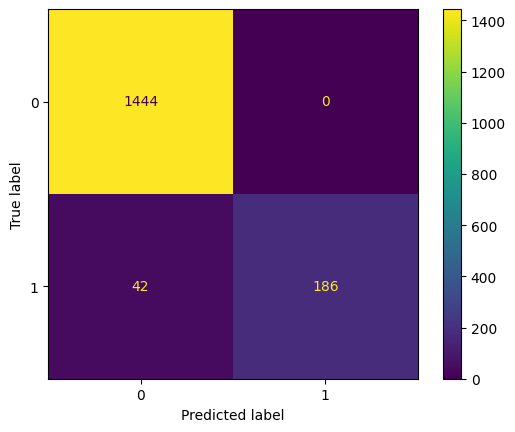

Confusion Matrix for the test set:


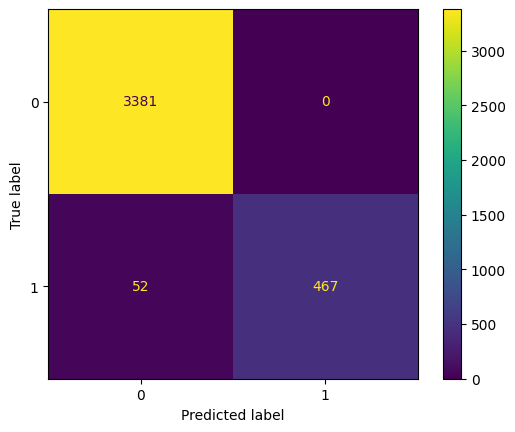

In [26]:
Confusion_matrix_train = confusion_matrix(yval,Y_test_pred)
ConfusionMatrixDisplay(Confusion_matrix_train).plot()
print('Confusion Matrix for the train set:')
plt.show()
Confusion_matrix_test = confusion_matrix(ytrain,Y_train_pred)
print('Confusion Matrix for the test set:')
ConfusionMatrixDisplay(Confusion_matrix_test).plot()
plt.show()

Even for the F1-score the results are pretty good for a simple model, however 0 being the legit message and 1 the spam as suspected we still have some false negative (8% of the total positive are predicted as negative), we will try another model in order to improve the results.

<h4> Transfer Learning <h4>

In order to improve our results which are already quite good we have been looking at the transfer learning using model already trained on billions of observation. We found the perfect model based on RoBERTa base model (https://huggingface.co/roberta-base) which is a model pretrained on English language. The one that we found: roberta-base-finetuned-sms-spam-detection, is a fined-tuned version train on the sms_spam dataset in order to recognize spam in sms (as the name may suggest). More information can be find here: https://huggingface.co/mariagrandury/roberta-base-finetuned-sms-spam-detection

Preprocessing for the model input

In [27]:
xtrain, xval, ytrain, yval = train_test_split(dataset.message_clean,dataset.label, test_size=0.3)
ytrain = encoder.fit_transform(ytrain)
yval = encoder.transform(yval)

In [28]:
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained('mariagrandury/roberta-base-finetuned-sms-spam-detection')
model = TFAutoModelForSequenceClassification.from_pretrained('mariagrandury/roberta-base-finetuned-sms-spam-detection',from_pt=True)

encoded_input = tokenizer(list(xval), return_tensors='tf', padding = True)
output = model(encoded_input)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFRobertaForSequenceClassification: ['roberta.embeddings.position_ids']
- This IS expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFRobertaForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFRobertaForSequenceClassification were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFRobertaForSequenceClassification for predictions without further training.


In [36]:
output_binary = [np.argmax(x) for x in output[0]]
print("accuracy on test set : ", accuracy_score(yval, output_binary))
print("f1-score on test set : ", f1_score(yval, output_binary))

accuracy on test set :  0.9868421052631579
f1-score on test set :  0.95


Confusion Matrix for the test set:


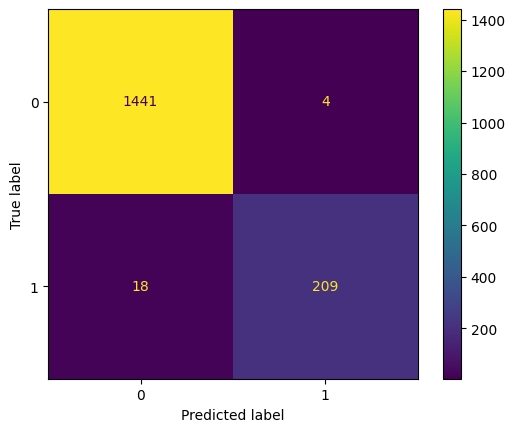

In [34]:
Confusion_matrix_test = confusion_matrix(yval, output_binary)
print('Confusion Matrix for the test set:')
ConfusionMatrixDisplay(Confusion_matrix_test).plot()
plt.show()

With this specific pre-trained model the f1-score on the test-set have indeed been improve of 5% compared to initial model (89% versus 95%) and the false negative have barely been divised by 3!

<h2> Conclusion <h2>

Even though we already had very good results with a quite simple model, the pre-trained for the same specific task of spam filtering 'roberta-base-finetuned-sms-spam-detection' model was obviously more efficient as despite the imbalance of the dataset we have been able to reach an accuracy of 0.98% (so a bit above the 97% of our initial model) and an f1-score of 95% (5% more than the baseline). Moreover the implementation have been quite easy.